In [64]:
import datetime, time

# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries
import shapely.geometry
import pyproj

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# Used for making the graph
import networkx as nx

# OpenTNSim
import opentnsim

In [65]:
def distance_over_path(FG, loc1, loc2):
    """This method determines the distance over a path between two points
    (NB: loc1 and loc2 are strings that define the names on the graph)"""

    wgs84 = pyproj.Geod(ellps='WGS84')

    # get path from graph
    path = nx.dijkstra_path(FG, loc1, loc2)

    # intitialise distance over path
    distance_over_path = 0

    # add the length of each path section to distance_path
    for node in enumerate(path[:-1]):
        orig = nx.get_node_attributes(FG, "geometry")[path[node[0]]]
        dest = nx.get_node_attributes(FG, "geometry")[path[node[0] + 1]]

        distance_over_path += int(wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y,
                                            shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2])

        if node[0] + 2 == len(path):
            break

    return distance_over_path

In [66]:
# We're in engineering cordinates (m)
coords = [
    [0,0],
    [0.8983,0], 
    [1.7966,0],
    [1.7966,1.3566],
    [1.7966,2.2609],
    [2.7527,0.9560],
    [3.3903,1.5931],
    [3.1441,0],
    [4.0424, 0],
    [1.9560,-0.1593],
    [3.3904,-1.5931]] 


# these are the indices of the points above
edge_indices = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [2, 5],
    [5, 6],
    [2, 7],
    [7, 8],
    [2, 9],
    [9, 10]   
]

depths = [12.5, 6, 6, 6, 4.5, 6, 2.5, 6, 2.5, 6] 

widths = [300, 150, 150, 150, 150, 150, 150, 150, 150, 150]

points = [
    shapely.geometry.Point(*coord )
    for coord 
    in coords
]

In [67]:
# define Site class
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

In [68]:
FG = nx.DiGraph()

nodes = []
for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(points[index].x, points[index].y)}
    nodes.append(Node(**data_node))

for node in nodes:
    FG.add_node(node.name, geometry = node.geometry)    
    
for index, edge in enumerate(edge_indices):
    edge_geometry = shapely.geometry.LineString([points[edge[0]], points[edge[1]]])
    edge_properties = dict(
        GeneralDepth = depths[index],
        width = widths[index],
        geometry = edge_geometry, 
        length = round(edge_geometry.length),
        e = tuple(edge)
    )
    FG.add_edge("Node " + str(edge[0]), "Node " + str(edge[1]), weight = 1, Info = edge_properties)

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

In [69]:
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)

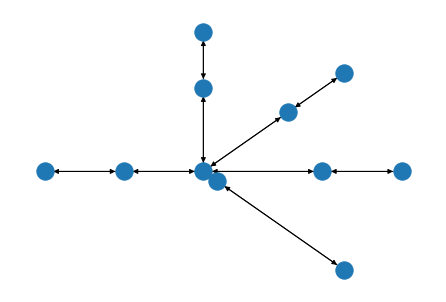

In [70]:
# show graph
nx.draw(FG, positions)
plt.show()

In [71]:
FG.edges[('Node 0', 'Node 1')]

{'weight': 1,
 'Info': {'GeneralDepth': 12.5,
  'width': 300,
  'geometry': <shapely.geometry.linestring.LineString at 0x1c9bae798b0>,
  'length': 1,
  'e': (0, 1)}}

In [72]:
# inspect if properties were set correctly
for edge in FG.edges(data = True):
    print('{}, {}: general depth {} m'.format(edge[0], edge[1], FG.edges[(edge[0], edge[1])]['Info']['GeneralDepth']))
    print('Distance from {} to {} is {} m'.format(edge[0], edge[1],distance_over_path(FG, edge[0], edge[1])))

Node 0, Node 1: general depth 12.5 m
Distance from Node 0 to Node 1 is 99998 m
Node 1, Node 0: general depth 12.5 m
Distance from Node 1 to Node 0 is 99998 m
Node 1, Node 2: general depth 6 m
Distance from Node 1 to Node 2 is 99998 m
Node 2, Node 1: general depth 6 m
Distance from Node 2 to Node 1 is 99998 m
Node 2, Node 3: general depth 6 m
Distance from Node 2 to Node 3 is 150005 m
Node 2, Node 5: general depth 4.5 m
Distance from Node 2 to Node 5 is 150004 m
Node 2, Node 7: general depth 2.5 m
Distance from Node 2 to Node 7 is 150003 m
Node 2, Node 9: general depth 2.5 m
Distance from Node 2 to Node 9 is 25002 m
Node 3, Node 2: general depth 6 m
Distance from Node 3 to Node 2 is 150005 m
Node 3, Node 4: general depth 6 m
Distance from Node 3 to Node 4 is 99993 m
Node 4, Node 3: general depth 6 m
Distance from Node 4 to Node 3 is 99993 m
Node 5, Node 2: general depth 4.5 m
Distance from Node 5 to Node 2 is 150004 m
Node 5, Node 6: general depth 6 m
Distance from Node 5 to Node 6 is 9

In [73]:
# inspect if properties were set correctly
for edge in FG.edges(data = True):
    print('{}, {}: general depth {} m'.format(edge[0], edge[1], FG.edges[(edge[0], edge[1])]['Info']['GeneralDepth']))

Node 0, Node 1: general depth 12.5 m
Node 1, Node 0: general depth 12.5 m
Node 1, Node 2: general depth 6 m
Node 2, Node 1: general depth 6 m
Node 2, Node 3: general depth 6 m
Node 2, Node 5: general depth 4.5 m
Node 2, Node 7: general depth 2.5 m
Node 2, Node 9: general depth 2.5 m
Node 3, Node 2: general depth 6 m
Node 3, Node 4: general depth 6 m
Node 4, Node 3: general depth 6 m
Node 5, Node 2: general depth 4.5 m
Node 5, Node 6: general depth 6 m
Node 6, Node 5: general depth 6 m
Node 7, Node 2: general depth 2.5 m
Node 7, Node 8: general depth 6 m
Node 8, Node 7: general depth 6 m
Node 9, Node 2: general depth 2.5 m
Node 9, Node 10: general depth 6 m
Node 10, Node 9: general depth 6 m


In [74]:
row = {
    "rws_type": "M8",
    "fuel": 3000,
    "H2": 999000,
    "Battery": 3300,
    "E-LNG": 432000,
    "E-Methanol": 165900
}
rows = [row]
ships = pd.DataFrame(rows)
ships

,rws_type,fuel,H2,Battery,E-LNG,E-Methanol
0,M8,3000,999000,3300,432000,165900


In [75]:
def split_edge(edge, distance):
    """compute points (list of shapely points) and edges ({e: linestring}) that we can use to replace an edge by points in between"""
    distances = np.arange(0, edge['geometry'].length + distance, distance)
    
    # The determine the points based on the distances
    points = [
        edge['geometry'].interpolate(distance) 
        for distance 
        in distances
    ]
    
    return points

def split_and_replace_edge(FG, e_replace, edge_info, distance):
    """remove edge from the network and replace it by points in between"""
    
    # determine the points that we want to intersect
    intersection_points = split_edge(edge_info, distance=distance)
    
    # Try and remove the previous edges, if it fails, that's ok
    try:
        FG.remove_edge(e_replace[0], e_replace[1])
    except nx.NetworkXError:
        pass
    
    # also remove the oposite edge direction
    try:
        FG.remove_edge(e_replace[1], e_replace[0])
    except nx.NetworkXError:
        pass

    # define Site class
    Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})
    
    # start at the start of our replaced edge
    nodes = []

    node_id = f'{e_replace[0]}'
    node_properties = dict(
        name=node_id,
        geometry=shapely.geometry.Point((edge_info['geometry'].xy[0][0], edge_info['geometry'].xy[1][0]))
    )
    nodes.append(node_properties)

    # all the points in between
    for node_i, point in enumerate(intersection_points[1:-1]):
        node_id = f'{e_replace[0]}-{node_i}-{e_replace[1]}'
        node_properties = dict(
            name=node_id,
            geometry=point,
        )
        nodes.append(node_properties)
    
    # end at the end of our edge
    node_id = f'{e_replace[1]}'
    node_properties = dict(
        name=node_id,
        geometry=shapely.geometry.Point((edge_info['geometry'].xy[0][1], edge_info['geometry'].xy[1][1]))
    )
    nodes.append(node_properties)

    # add the nodes in between
    for node in nodes:
        FG.add_node(node['name'], geometry = node['geometry'])    
        
    # now loop over all the node pairs in between our edge
    edges = []
    for index, node in enumerate(nodes[:-1]):
        e = (nodes[index]['name'], nodes[index+1]['name'])

        # create a new geometry
        edge_geometry = shapely.geometry.LineString([
            nodes[index]['geometry'], 
            nodes[index+1]['geometry']
        ])
        # we might want to copy the old properties
        # for now this is hard coded
        # at least replace e, edge_geometry
        edge_properties = dict(
            GeneralDepth= edge_info['GeneralDepth'], 
            width= edge_info['width'], 
            geometry=edge_geometry, 
            length=edge_geometry.length,
            e=tuple(e)
        )
        edges.append(edge_properties)

    # now that we have all our edges computed
    for edge in edges:
        # insert them in two directions
        e = edge['e']
        FG.add_edge(e[0], e[1], weight = 1, Info = edge_properties)
        FG.add_edge(e[1], e[0], weight = 1, Info = edge_properties)

    
    return FG, nodes, edges

In [76]:
distance = 10000
edge_name = ("Node " + str(edge_indices[0][0]), "Node " + str(edge_indices[0][1]))
print(edge_name)
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_0 = split_and_replace_edge(FG, edge_name, edge_info, distance=distance)

edge_name = ("Node " + str(edge_indices[1][0]), "Node " + str(edge_indices[1][1]))
print(edge_name)
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_1 = split_and_replace_edge(FG, edge_name, edge_info, distance=distance)

edge_name = ("Node " + str(edge_indices[2][0]), "Node " + str(edge_indices[2][1]))
print(edge_name)
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_2 = split_and_replace_edge(FG, edge_name, edge_info, distance=distance)

edge_name = ("Node " + str(edge_indices[3][0]), "Node " + str(edge_indices[3][1]))
print(edge_name)
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_3 = split_and_replace_edge(FG, edge_name, edge_info, distance=distance)

edge_name = ("Node " + str(edge_indices[4][0]), "Node " + str(edge_indices[4][1]))
print(edge_name)
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_4 = split_and_replace_edge(FG, edge_name, edge_info, distance=distance)

edge_name = ("Node " + str(edge_indices[5][0]), "Node " + str(edge_indices[5][1]))
print(edge_name)
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_5 = split_and_replace_edge(FG, edge_name, edge_info, distance=distance)

edge_name = ("Node " + str(edge_indices[6][0]), "Node " + str(edge_indices[6][1]))
print(edge_name)
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_6 = split_and_replace_edge(FG, edge_name, edge_info, distance=distance)

edge_name = ("Node " + str(edge_indices[7][0]), "Node " + str(edge_indices[7][1]))
print(edge_name)
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_7 = split_and_replace_edge(FG, edge_name, edge_info, distance=distance)

edge_name = ("Node " + str(edge_indices[8][0]), "Node " + str(edge_indices[8][1]))
print(edge_name)
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_8 = split_and_replace_edge(FG, edge_name, edge_info, distance=distance)

edge_name = ("Node " + str(edge_indices[9][0]), "Node " + str(edge_indices[9][1]))
print(edge_name)
edge_info = FG.edges[edge_name]['Info']
FG, nodes, split_edge_9 = split_and_replace_edge(FG, edge_name, edge_info, distance=distance)

('Node 0', 'Node 1')
('Node 1', 'Node 2')
('Node 2', 'Node 3')
('Node 3', 'Node 4')
('Node 2', 'Node 5')
('Node 5', 'Node 6')
('Node 2', 'Node 7')
('Node 7', 'Node 8')
('Node 2', 'Node 9')
('Node 9', 'Node 10')


In [77]:
positions = {}
for node in FG.nodes:
    positions[node] = (FG.nodes[node]['geometry'].x, FG.nodes[node]['geometry'].y)   

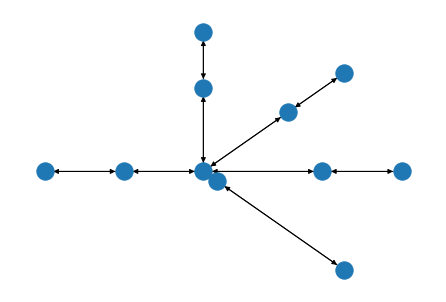

In [78]:
# show graph
nx.draw(FG, positions)
plt.show()

In [79]:
for edge in FG.edges:
    print(edge)
    print(FG.edges[edge]['Info']['length'])

('Node 0', 'Node 1')
0.8983
('Node 1', 'Node 0')
0.8983
('Node 1', 'Node 2')
0.8983
('Node 2', 'Node 1')
0.8983
('Node 2', 'Node 3')
1.3566
('Node 2', 'Node 5')
1.3520588781558294
('Node 2', 'Node 7')
1.3475
('Node 2', 'Node 9')
0.22535494225776365
('Node 3', 'Node 2')
1.3566
('Node 3', 'Node 4')
0.9042999999999999
('Node 4', 'Node 3')
0.9042999999999999
('Node 5', 'Node 2')
1.3520588781558294
('Node 5', 'Node 6')
0.901349083318999
('Node 6', 'Node 5')
0.901349083318999
('Node 7', 'Node 2')
1.3475
('Node 7', 'Node 8')
0.8982999999999999
('Node 8', 'Node 7')
0.8982999999999999
('Node 9', 'Node 2')
0.22535494225776365
('Node 9', 'Node 10')
2.0281237141752473
('Node 10', 'Node 9')
2.0281237141752473


Weird distances: 
* from 2 - 9  --> 5000.46
* from 9 - 10 --> 4999.96
* from 5 - 6  --> 0.4552

In [80]:
df_split_edge_0 = pd.DataFrame(split_edge_0)
df_split_edge_0.head(3)

,GeneralDepth,width,geometry,length,e
0,12.5,300,"LINESTRING (0 0, 0.8983 0)",0.8983,"(Node 0, Node 1)"


In [81]:
df_split_edge_1 = pd.DataFrame(split_edge_1)
df_split_edge_1.head(3)

,GeneralDepth,width,geometry,length,e
0,6,150,"LINESTRING (0.8983 0, 1.7966 0)",0.8983,"(Node 1, Node 2)"


In [82]:
df_split_edge_2 = pd.DataFrame(split_edge_2)
df_split_edge_2.head(3)

,GeneralDepth,width,geometry,length,e
0,6,150,"LINESTRING (1.7966 0, 1.7966 1.3566)",1.3566,"(Node 2, Node 3)"


In [83]:
df_split_edge_3 = pd.DataFrame(split_edge_3)
df_split_edge_3.head(3)

,GeneralDepth,width,geometry,length,e
0,6,150,"LINESTRING (1.7966 1.3566, 1.7966 2.2609)",0.9043,"(Node 3, Node 4)"


In [84]:
df_split_edge_4 = pd.DataFrame(split_edge_4)
df_split_edge_4.head(3)

,GeneralDepth,width,geometry,length,e
0,4.5,150,"LINESTRING (1.7966 0, 2.7527 0.956)",1.352059,"(Node 2, Node 5)"


In [85]:
df_split_edge_5 = pd.DataFrame(split_edge_5)
df_split_edge_5.head(3)

,GeneralDepth,width,geometry,length,e
0,6,150,"LINESTRING (2.7527 0.956, 3.3903 1.5931)",0.901349,"(Node 5, Node 6)"


In [86]:
df_split_edge_6 = pd.DataFrame(split_edge_6)
df_split_edge_6.head(3)

,GeneralDepth,width,geometry,length,e
0,2.5,150,"LINESTRING (1.7966 0, 3.1441 0)",1.3475,"(Node 2, Node 7)"


In [87]:
df_split_edge_7 = pd.DataFrame(split_edge_7)
df_split_edge_7.head(3)

,GeneralDepth,width,geometry,length,e
0,6,150,"LINESTRING (3.1441 0, 4.0424 0)",0.8983,"(Node 7, Node 8)"


In [88]:
df_split_edge_8 = pd.DataFrame(split_edge_8)
df_split_edge_8.head(3)

,GeneralDepth,width,geometry,length,e
0,2.5,150,"LINESTRING (1.7966 0, 1.956 -0.1593)",0.225355,"(Node 2, Node 9)"


In [89]:
df_split_edge_9 = pd.DataFrame(split_edge_9)
df_split_edge_9.head(3)

,GeneralDepth,width,geometry,length,e
0,6,150,"LINESTRING (1.956 -0.1593, 3.3904 -1.5931)",2.028124,"(Node 9, Node 10)"


### Create vessels - add VesselProperties and ConsumesEnergy mixins

In [90]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.core.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [91]:
# Create a dict with all important settings
# NB: set both "v" and "P_tot_given" to None, as they will be set later
# Note that we set "h_squat" as "True". 
# The squat effect makes a great difference for the actual water depth and resistance calculation in shallow water. 
# Here we need to calculate the water depth reduced by squat since what we give the ship is a route with undisturbed water depth h_0.

data_vessel = {"env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": 3.5,  # m/s
               "type":None,
               "B": 11.4,
               "L": 110,
               "H_e": None, 
               "H_f": None, 
               "T": None,
               "safety_margin": 0.2, # for tanker vessel with sandy bed the safety margin is recommended as 0.2 m
               "h_squat": True, # if consider the ship squat while moving, set to True, otherwise set to False. 
               "P_installed": 1750.0,
               "P_tot_given": None, # kW
               "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
               "P_hotel_perc": 0.05,
               "P_hotel": None, # None: calculate P_hotel from percentage
               "x": 2 ,
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":1990,
              }             

vessel = TransportResource(**data_vessel)

### Run simulation

In [92]:
def run_simulation(FG, V_s, T, path):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.v = V_s
    vessel._T = T
    # vessel.P_tot_given = P_tot_given    

    # Start the simulation
    env.process(vessel.move())
    env.run()
    print (vessel._T)
    return vessel

### Define paths

In [93]:
path_0 = nx.dijkstra_path(FG, 'Node 0', 'Node 4' )
path_1 = nx.dijkstra_path(FG, 'Node 0', 'Node 6' )
path_2 = nx.dijkstra_path(FG, 'Node 0', 'Node 8' )
path_3 = nx.dijkstra_path(FG, 'Node 0', 'Node 10' )

In [94]:
path_0

['Node 0', 'Node 1', 'Node 2', 'Node 3', 'Node 4']

In [95]:
run_simulation(FG, V_s=3, T=2.5, path=path_0)

I am at Node 0
I am going to go to the next node Node 1
distance: 99998.29857959764 m
v: 3 m/s
I am at Node 1
I am going to go to the next node Node 2
distance: 99998.29857959764 m
v: 3 m/s
I am at Node 2
I am going to go to the next node Node 3
distance: 150005.34402692903 m
v: 3 m/s
I am at Node 3
I am going to go to the next node Node 4
distance: 99993.33874912799 m
v: 3 m/s
2.5
